<a href="https://colab.research.google.com/github/HoseinNekouei/Twitter-Financial-News-Sentiment/blob/main/Tweet_Financial_News_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import transformers
transformers_version = transformers.__version__

if transformers_version > '4.31.1':
  !pip uninstall transformers
  !pip install transformers==4.31
else:
  print("transformers version:", transformers.__version__)

transformers version: 4.31.0


In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import keras
print("Keras version:", keras.__version__)

TensorFlow version: 2.15.0
Keras version: 2.15.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading the Data ###

In [4]:
import pandas as pd

# Load the CSV file in memory
train_path = '/content/drive/MyDrive/dataset/Twitter_Financial_News_Sentiment/train.csv'
test_path = '/content/drive/MyDrive/dataset/Twitter_Financial_News_Sentiment/test.csv'

train_df = pd.read_csv(train_path, usecols=['text', 'label'])
test_df = pd.read_csv(test_path, usecols=['text', 'label'])

Show example

In [5]:
train_df.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


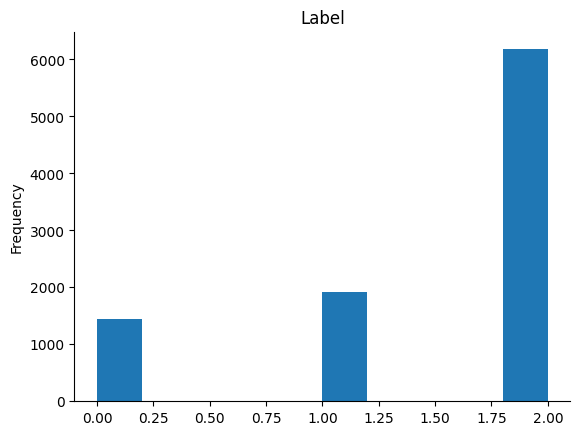

In [6]:
#import matplotlib library
from matplotlib import pyplot as plt

#Histogram of "Label" column in train datset
train_df['label'].plot(kind='hist', title='Label')
plt.gca().spines[['top', 'right']].set_visible(False)

In [7]:
test_df.head()

,text,label
0,$ALLY - Ally Financial pulls outlook https://t...,0
1,"$DELL $HPE - Dell, HPE targets trimmed on comp...",0
2,$PRTY - Moody's turns negative on Party City h...,0
3,$SAN: Deutsche Bank cuts to Hold,0
4,$SITC: Compass Point cuts to Sell,0


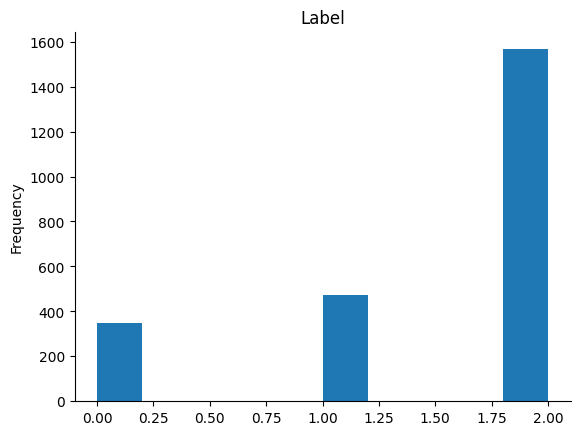

In [8]:
#import matplotlib library
from matplotlib import pyplot as plt

#Histogram of "Label" column in train datset
test_df['label'].plot(kind='hist', title='Label')
plt.gca().spines[['top', 'right']].set_visible(False)

In [9]:
# Pritn theshape of datasets
print(f'train_df shape: {train_df.shape}')
print(f'test_df shape: {test_df.shape}')

train_df shape: (9543, 2)
test_df shape: (2388, 2)


### Removing the Special Characters ###

In [10]:

# !pip install text_hammer

# import text_hammer as th

def text_proccessing(df, col_name):
  """
  Process text data in a DataFrame column by performing the following operations:

  1. Convert text to lowercase.
  2. Remove emails from the text.
  3. Remove accented characters from the text.
  4. Remove URLs from the text.

  Parameters:
  df (DataFrame): Input DataFrame containing text data.
  col_name (str): Name of the column in the DataFrame containing text data.

  Returns:
  DataFrame: Processed DataFrame with text data after applying the specified operations.
  """

  df[col_name] = df[col_name].apply(lambda x:str(x).lower())
  df[col_name] = df[col_name].apply(lambda x: th.remove_emails(x))
  df[col_name] = df[col_name].apply(lambda x: th.remove_accented_chars(x))
  df[col_name] = df[col_name].apply(lambda x: th.remove_urls(x))

  return df

# train_df = text_proccessing(train_df, 'text')


In [11]:
# Print the first sample after cleaning data
train_df['text'].iloc[0:5]

0    $BYND - JPMorgan reels in expectations on Beyo...
1    $CCL $RCL - Nomura points to bookings weakness...
2    $CX - Cemex cut at Credit Suisse, J.P. Morgan ...
3    $ESS: BTIG Research cuts to Neutral https://t....
4    $FNKO - Funko slides after Piper Jaffray PT cu...
Name: text, dtype: object

###Loading PreTrained BERT Model###

In [12]:
from transformers import AutoTokenizer, TFBertModel
tokenizer =  AutoTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [13]:
tokenizer(train_df['text'].iloc[0])

{'input_ids': [101, 1002, 2011, 4859, 1011, 16545, 5302, 16998, 15934, 2015, 1999, 10908, 2006, 3458, 6240, 16770, 1024, 1013, 1013, 1056, 1012, 2522, 1013, 1038, 2094, 2692, 2595, 29292, 2290, 15992, 2102, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [14]:
max_len = max([len(x.split()) for x in train_df.text])
print(f'Max len of tweets: {max_len}')

Max len of tweets: 32


In [15]:
x_train = tokenizer(
                text = train_df.text.tolist(),
                padding = True,
                max_length= 36,
                truncation= True,
                return_tensors = 'tf')

print(x_train)

{'input_ids': <tf.Tensor: shape=(9543, 36), dtype=int32, numpy=
array([[  101,  1002,  2011, ...,     0,     0,     0],
       [  101,  1002, 10507, ...,  5596,  2509,   102],
       [  101,  1002,  1039, ...,  2290,  2549,   102],
       ...,
       [  101, 28879,  2615, ...,     0,     0,     0],
       [  101,  2147,  1010, ...,     0,     0,     0],
       [  101,  1061,  4859, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(9543, 36), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(9543, 36), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32

In [16]:
print(x_train['input_ids'].shape)
print(x_train['attention_mask'].shape)

(9543, 36)
(9543, 36)


In [17]:
print(train_df.label.value_counts())

label
2    6178
1    1923
0    1442
Name: count, dtype: int64


In [18]:
y_train = train_df.label.values
y_train


array([0, 0, 0, ..., 2, 2, 2])

### Building the Model Architecture ###

In [19]:
from keras import layers, Model

max_length = 36

input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
input_mask = layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

embeddings = bert(input_ids,attention_mask = input_mask)[1] #(0 is the last hidden states,1 means pooler_output)

out = layers.Dropout(0.2)(embeddings)
out = layers.Dense(128, activation='relu')(out)
out = layers.Dropout(0.2)(out)
out = layers.Dense(32,activation = 'relu')(out)

y = layers.Dense(3,activation = 'softmax')(out)

model = Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 36)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 36)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 36, 76                                       

In [21]:
from keras.optimizers import Adam

optimizer = Adam(
    learning_rate = 6e-06, # this learning rate is for bert model , taken from huggingface website
    epsilon=1e-08,
    weight_decay=0.01)

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics = ["sparse_categorical_accuracy"])

In [22]:
train_history = model.fit(
    x = {'input_ids':x_train['input_ids'], 'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_split = 0.1,
    epochs= 8,
    batch_size= 32)

Epoch 1/8
269/269 [==============================] - 157s 322ms/step - loss: 0.7485 - sparse_categorical_accuracy: 0.6950 - val_loss: 0.7132 - val_sparse_categorical_accuracy: 0.6901
Epoch 2/8
269/269 [==============================] - 78s 290ms/step - loss: 0.5563 - sparse_categorical_accuracy: 0.7706 - val_loss: 0.5025 - val_sparse_categorical_accuracy: 0.8168
Epoch 3/8
269/269 [==============================] - 79s 295ms/step - loss: 0.4216 - sparse_categorical_accuracy: 0.8487 - val_loss: 0.4202 - val_sparse_categorical_accuracy: 0.8461
Epoch 4/8
269/269 [==============================] - 78s 290ms/step - loss: 0.3288 - sparse_categorical_accuracy: 0.8822 - val_loss: 0.3962 - val_sparse_categorical_accuracy: 0.8534
Epoch 5/8
269/269 [==============================] - 79s 295ms/step - loss: 0.2575 - sparse_categorical_accuracy: 0.9122 - val_loss: 0.4610 - val_sparse_categorical_accuracy: 0.8398
Epoch 6/8
269/269 [==============================] - 79s 294ms/step - loss: 0.1989 - spar

#### TESTING PHASE
on this phase we will make predictions out of our model

In [23]:
x_test = tokenizer(
    text = test_df.text.tolist(),
    padding= True,
    max_length= 36,
    truncation = True,
    return_tensors= 'tf')

In [24]:
y_test = test_df.label.values
y_test

array([0, 0, 0, ..., 2, 2, 2])

In [25]:
predicted = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

75/75 [==============================] - 11s 87ms/step


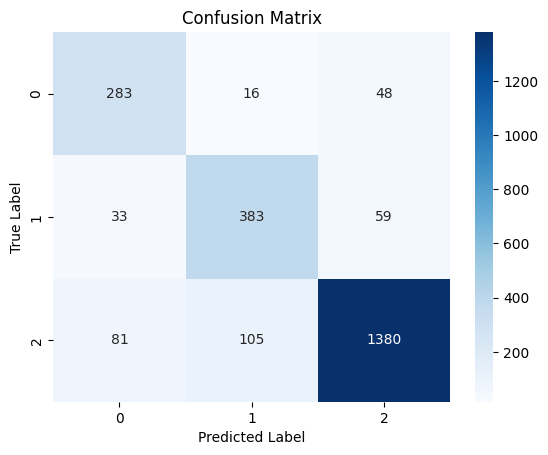

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Convert the predictions to class labels (0, 1, or 2 for 3 classes)
y_pred_classes = np.argmax(predicted, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(test_df['label'], y_pred_classes)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [27]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(test_df['label'], y_pred_classes)

print(report)

              precision    recall  f1-score   support

           0       0.71      0.82      0.76       347
           1       0.76      0.81      0.78       475
           2       0.93      0.88      0.90      1566

    accuracy                           0.86      2388
   macro avg       0.80      0.83      0.82      2388
weighted avg       0.86      0.86      0.86      2388

